In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import imageio
from glob import glob
import scipy
import scipy.spatial
import pandas as pd
import pickle
import skimage
import skimage.transform

import skimage.util
import skimage.exposure

from skimage.color import rgb2gray
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
import random

%matplotlib inline

In [2]:
data_dir = Path("../Datasets/cifar/")

In [3]:
for p in data_dir.iterdir():
    print(p)

../Datasets/cifar/学習データcifar.zip
../Datasets/cifar/labels.csv
../Datasets/cifar/.DS_Store
../Datasets/cifar/test
../Datasets/cifar/学習データcifar
../Datasets/cifar/labels.txt
../Datasets/cifar/train


In [4]:
train_path = data_dir / "train"

In [5]:
imgs = list(train_path.glob("*.png"))
len(imgs)

50000

In [6]:
def get_resize_img(path, dim=28):
    img = imread(path)
    return skimage.transform.resize(img, [dim,dim, 3], mode="reflect")

def get_flatten_img(path, dim=28, invert_gray=False):
    if invert_gray:
        img = 255 - imread(path)
    else:
        img = imread(path)
    return rgb2gray(skimage.transform.resize(img, [dim, dim], mode="reflect"))

def imread(path):
    return imageio.imread(path)

def horizontal_flip(image):
    return image[:, ::-1, :]

def vertical_flip(image): 
    return image[::-1, :]

def rotate_image(image, angle=random.randint(-15, 15)):
    return skimage.transform.rotate(image, angle=angle, resize=False, center=None)

def random_noise(image):
    return skimage.util.random_noise(image)

def invert_color(image):
    return np.invert(image)

def rescale_image(image):
    return skimage.transform.rescale(image, 1.0 / 4.0)

def rescale_intensity(image):
    v_min, v_max = np.percentile(image.astype(np.uint8), (0.2, 99.8))
    return skimage.exposure.rescale_intensity(image.astype(np.uint8), in_range=(v_min, v_max))

def adjust_gamma(image): 
    return skimage.exposure.adjust_gamma(image, gamma=0.4, gain=0.9)

In [7]:
img = imread("/Users/tdual/Downloads/ponde.jpeg")

In [8]:
images = [
    img, 
    horizontal_flip(img), 
    rotate_image(img),
    vertical_flip(img), 
    random_noise(img),
    invert_color(img), 
    rescale_intensity(img), 
    adjust_gamma(img)
]

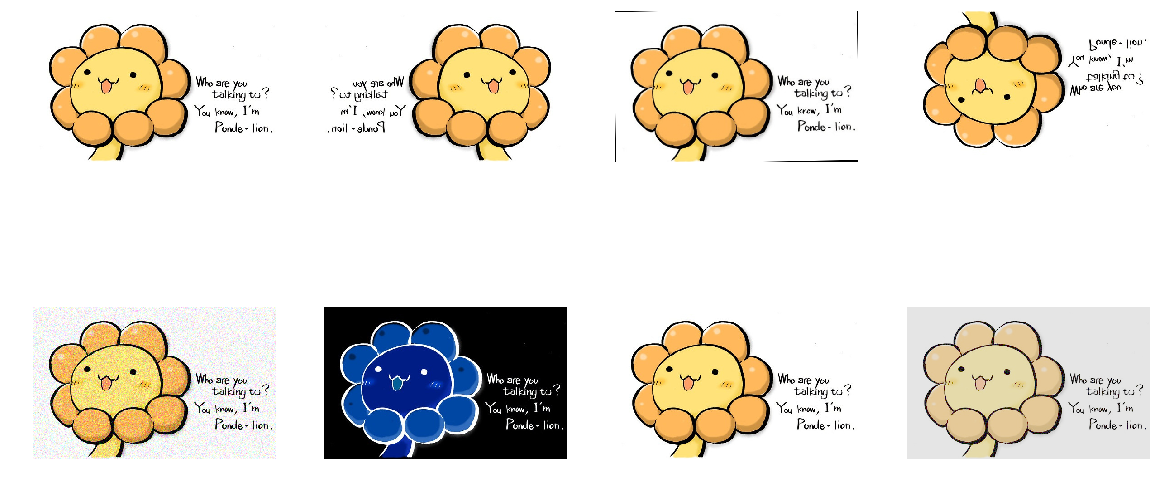

In [9]:
fig, axs = plt.subplots(2, int(len(images)/2), figsize=(20, 10))
for i, image in enumerate(images):
        if i < len(images)/2:
            y = 0
            x = i
        else:
            y = 1
            x = i - int( len(images)/2)
        axs[y][x].imshow(image)
        axs[y][x].axis('off')
plt.show()

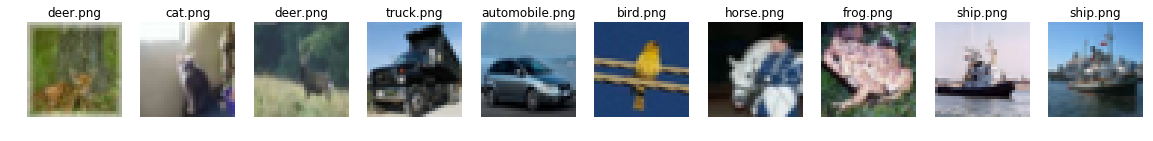

In [10]:
test = imgs[:10]
fig, axs = plt.subplots(1, len(test), figsize=(20, 3))
for i, path in enumerate(test):
        axs[i].imshow(imread(path))
        axs[i].axis('off')
        label = path.name.split("_")[1]
        axs[i].set_title( label)
plt.show()

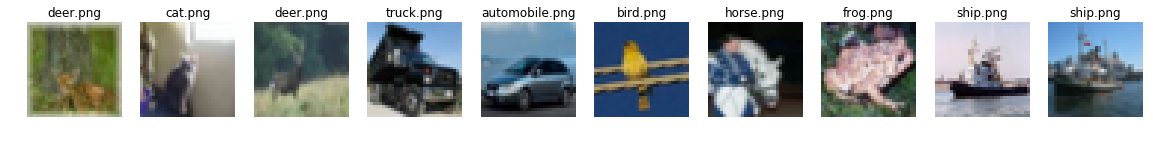

In [11]:
test = imgs[:10]
fig, axs = plt.subplots(1, len(test), figsize=(20, 3))
for i, path in enumerate(test):
        axs[i].imshow(horizontal_flip(imread(path)))
        axs[i].axis('off')
        label = path.name.split("_")[1]
        axs[i].set_title( label)
plt.show()

In [12]:
imread(imgs[0]).shape

(32, 32, 3)

In [16]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)


def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)


def conv2d(x, filt, name):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        filt is a filter. filt.shape is [filter_height, filter_width, in_channels, out_channels]
    """ 
    return tf.nn.conv2d(x, filt, strides=[1,1,1,1], padding='SAME', name=name)


def max_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def max_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.avg_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def conv_layer(x, out_size, name, filter_size=5, act="relu"):
    shape =x.get_shape().as_list()
    in_channel = shape[-1]
    with tf.name_scope("conv_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([filter_size, filter_size, in_channel, out_size])
            variable_summaries(W)        
        with tf.name_scope('biases'):
            b = bias_variable([out_size])
            variable_summaries(b)
        h_conv = conv2d(x, W, "conv2d_{}".format(name))
        h = tf.nn.bias_add(h_conv, b)
        variable_summaries(h)
        
    if act == "relu":
        with tf.name_scope("conv_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def fc_layer(x_flatten, out_size, name, act="relu"):
    shape =x_flatten.get_shape().as_list()
    dim = shape[1]
    with tf.name_scope("fc_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([dim, out_size])
        with tf.name_scope('biases'):   
            b  = bias_variable([out_size])
        h = tf.nn.bias_add(tf.matmul(x_flatten, W), b)
      
    if act == "relu":
        with tf.name_scope("fc_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def dropout(x, keep_prob, name):
    with tf.name_scope("dropout_{}".format(name)):
        h = tf.nn.dropout(x, keep_prob)
    return h
    

def flatten(x, name):
    shape = x.get_shape().as_list()
    dim = 1
    for s in shape[1:]:
        dim *= s
    with tf.name_scope(name):
        h = tf.reshape(x, [-1, dim])
    return h


def get_channel(x):
    shape = x.get_shape().as_list()
    return shape[-1]

def block(x, out_size, name):
    h_conv_act = conv_layer(x, out_size, name)
    
    with tf.name_scope("pool_{}".format(name)):   
        h_pool1 = max_pool(h_conv_act, name)
        variable_summaries(h_pool1)
    return h_pool1

def vgg_block(x, out_sizes, name):
    """
     x is a batch of images.
     out_sizes is a list of cnn layer sizes.
     name is this function's name. 
    """
    for idx, size in enumerate(out_sizes):
        if idx == 0:
            _x = x
        else:
            _x = h
        h = conv_layer(_x, size, "{}_{}".format(name, idx), filter_size=3)
        
    
    with tf.name_scope("pool_{}".format(name)):   
        h_pool1 = max_pool(h, name)
        variable_summaries(h_pool1)
    return h_pool1


def variable_summaries(var):  
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [17]:
height = 32
width = 32
channel = 3
image_size = height * width

In [68]:
g1 = None

# VGG16

with tf.Graph().as_default() as g1:
    keep_prob = tf.placeholder(tf.float32)
    global_step =  tf.placeholder(tf.int32)
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[None, height, width, channel], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')


    h_pool1 = vgg_block(tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), x), [32, 32], "1") # original size: 64
    h_pool2 = vgg_block(h_pool1, [64, 64], "2") # original size: 128
    h_pool3 = vgg_block(h_pool2, [128, 128, 128], "3") # original size: 256
    h_pool4 = vgg_block(h_pool3, [256, 256, 256], "4") # original size: 512
    h_pool5 = vgg_block(h_pool4, [256, 256, 256], "5") # original size: 512
    h_pool_flat = flatten(h_pool5, "pool_flat")
    h_fc1 = fc_layer(h_pool_flat, 1024, "1", act="relu") # original size: 4096
    h_fc1_drop = dropout(h_fc1, keep_prob, "fc1")
    h_fc2 = fc_layer(h_fc1_drop, 1024, "2", act="relu") # original size: 4096
    h_fc2_drop = dropout(h_fc2, keep_prob, "fc2")
    y_conv = fc_layer(h_fc2_drop , 10, "3", act="ident") # original size: 1000
    
    #h_pool1 = block(x, 32, "1")
    #h_pool2 = block(h_pool1, 64, "2")
    #h_pool2_flat = flatten(h_pool2, "pool2_flat")
    #h_fc1 = fc_layer(h_pool2_flat, 1024, "1", act="relu")
    #h_fc1_drop = dropout(h_fc1, keep_prob, "fc1")
    #y_conv = fc_layer(h_fc1_drop , 10, "2", act="ident")

    with tf.name_scope("loss"):
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        tf.summary.scalar('cross_entropy', loss)

    with tf.name_scope("optimizer"):
        starter_learning_rate = 0.01
        #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,1000, 0.96, staircase=True)
        learning_rate = 1e-4
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

In [69]:
import tensorboard as tb 
tb.show_graph(g1)

In [70]:
def get_images(images_path):
    allow_file = ["jpeg","png","jpg","JPEG","JPG","PNG"]
    images = []
    for ext in allow_file:
        images += list(images_path.glob("*."+ext))
    return images


class ImageManager:
    def __init__(self):
        self.test_offset = 0
        self.train_offset = 0
        self.aug_funcs  = [
            horizontal_flip, 
            rotate_image,
            vertical_flip, 
            random_noise,
            invert_color, 
            rescale_intensity, 
            adjust_gamma
        ]

    def imread(self, path):
        return imageio.imread(path)

    def get_resize_gray_img(self, path):
        return rgb2gray(self.get_resize_img(path))

    def get_resize_img(self, path, dim=28, channel=3):
        img = self.imread(path)
        return skimage.transform.resize(img, [dim, dim, channel], mode="reflect")

    def get_flatten_img(self, path, dim=28, invert_gray=False):
        if invert_gray:
            img = 255 - self.imread(path)
        else:
            img = self.imread(path)
        return rgb2gray(skimage.transform.resize(img, [dim, dim], mode="reflect"))

    def load_data(self, path, ratio=0.1):
        p = Path(path)
        labels_path = p / "labels" / "labels.csv"
        self.labels = self.create_label_obj(labels_path)
        image_dir = p / "images"
        images = get_images(image_dir)
        self.n_images = len(images)
        
        print("# of original images: ", self.n_images)
        random.shuffle(images)
        
        print("test/train: ", ratio)
        n_test = int(self.n_images * ratio)
        self.test_images = images[:n_test]
        self.train_images = images[n_test:]
        
        self.n_test = len(self.test_images)
        self.n_train = len(self.train_images)

        print("test/train(original): {}/{} = {:.4}".format(self.n_test, self.n_train, self.n_test/self.n_train))
        

        
        if len(self.aug_funcs) > 0:
            self.train_images = [(img, i)for img in self.train_images for i in range(len(self.aug_funcs))]
            self.n_train = len(self.train_images)
            self.n_image = self.n_test + self.n_train
            print("# of augmented images: ", self.n_image)
            random.shuffle(self.train_images)
            print("test/train(augmented): {}/{} = {:.4}".format(self.n_test, self.n_train, self.n_test/self.n_train))


    

    def create_label_obj(self, path):
        labels = {}
        mapping_dic = {}

        with open(path, "r") as f:
            for line in f:
                filename = line.split(",")[0]
                label = line.split(",")[1][:-1]
                if label in mapping_dic.keys():
                    mapped_label = mapping_dic[label]
                else:
                    length = len(mapping_dic)
                    mapping_dic[label] = length
                    mapped_label = length
                labels[filename] = mapped_label
        self.mapping_dic = mapping_dic
        print(self.mapping_dic)
        return labels

    def next_batch(self, kind, num, one_hot=True):
        if kind == "test":
            
            end = self.test_offset + num
            if end > self.n_test:
                self.test_offset = 0
                end = num
                random.shuffle(self.test_images)
            images = self.test_images
            offset = self.test_offset
            image_paths = images[offset: end]
            label_batch = [np.identity(10)[self.labels[p.name]] for p in image_paths]
            image_batch = [self.imread(str(p)) for p in image_paths]
            
        elif kind == "train":
            end = self.train_offset + num
            if end > self.n_train:
                self.train_offset = 0
                end = num
                random.shuffle(self.train_images)
            images = self.train_images
            offset = self.train_offset
            
            image_paths = images[offset: end]
            label_batch = [np.identity(10)[self.labels[p[0].name]] for p in image_paths]
            image_batch = [self.aug_funcs[p[1]](self.imread(str(p[0]))) for p in image_paths]


        else:
            raise Exception("kind is 'test' or 'train'")

        if kind == "test":
            self.test_offset = end
        elif kind == "train":
            self.train_offset = end
        return label_batch, image_batch


In [71]:
ima = ImageManager()

In [72]:
import random
ima.load_data(data_dir/ "学習データcifar", ratio=0.05)

{'deer': 0, 'cat': 1, 'truck': 2, 'automobile': 3, 'bird': 4, 'horse': 5, 'frog': 6, 'ship': 7, 'dog': 8, 'airplane': 9}
# of original images:  50000
test/train:  0.05
test/train(original): 2500/47500 = 0.05263
# of augmented images:  335000
test/train(augmented): 2500/332500 = 0.007519


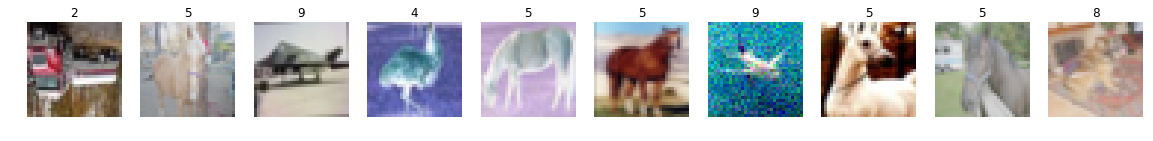

In [73]:
labels, images = ima.next_batch("train", 10)
fig, axs = plt.subplots(1, len(images), figsize=(20, 3))
for i, image in enumerate(images):
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(np.argmax(labels[i]))
plt.show()

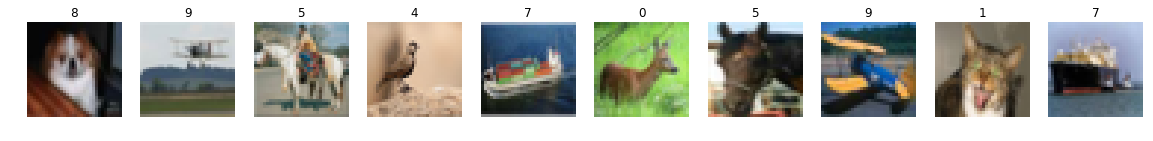

In [74]:
labels, images = ima.next_batch("test", 10)
fig, axs = plt.subplots(1, len(images), figsize=(20, 3))
for i, image in enumerate(images):
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(np.argmax(labels[i]))
plt.show()

In [75]:
image.shape

(32, 32, 3)

In [76]:
images_std = [tf.image.per_image_standardization(img) for img in images]

In [77]:
ima.n_train
batch_size = 100
batch_per_epoch = int(ima.n_train / batch_size)
batch_per_epoch

3325

In [78]:
n_epoch = 20

In [79]:
n_iter = batch_per_epoch * n_epoch
print(n_iter)

66500


In [80]:
log_dir= "logs"
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)



with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    for i in tqdm(range(n_iter)):
        labels, images = ima.next_batch("train", batch_size)
        _ = sess.run(opt, feed_dict={x: images, y_:  labels, keep_prob: 0.6, global_step: i})
        
        
        if i % 100 == 0 and i !=0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={x: images, y_: labels, keep_prob: 0.6})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
            
        if i % 500 == 0 and i !=0:
            labels, images = ima.next_batch("test", batch_size)
            test_loss, test_accuracy, test_summary, = sess.run([loss, accuracy, merged], feed_dict={x: images, y_: labels, keep_prob: 1.0})
            test_writer.add_summary(test_summary, 0)
            print('\nstep %d, test loss %g, test accuracy %g\n' % (i, test_loss, test_accuracy))

HBox(children=(IntProgress(value=0, max=66500), HTML(value='')))

step 100, training loss 18.5155, training accuracy 0.11
step 200, training loss 10.7436, training accuracy 0.08
step 300, training loss 5.79144, training accuracy 0.16
step 400, training loss 3.96579, training accuracy 0.11
step 500, training loss 2.90005, training accuracy 0.12

step 500, test loss 2.32196, test accuracy 0.15

step 600, training loss 2.49422, training accuracy 0.16
step 700, training loss 2.38838, training accuracy 0.12
step 800, training loss 2.41182, training accuracy 0.12
step 900, training loss 2.36277, training accuracy 0.16
step 1000, training loss 2.27861, training accuracy 0.14

step 1000, test loss 2.21569, test accuracy 0.17

step 1100, training loss 2.29177, training accuracy 0.14
step 1200, training loss 2.2192, training accuracy 0.17
step 1300, training loss 2.2476, training accuracy 0.15
step 1400, training loss 2.31978, training accuracy 0.17
step 1500, training loss 2.12497, training accuracy 0.25

step 1500, test loss 2.04304, test accuracy 0.23

step

step 12400, training loss 1.15694, training accuracy 0.59
step 12500, training loss 1.36106, training accuracy 0.48

step 12500, test loss 0.853786, test accuracy 0.73

step 12600, training loss 1.05545, training accuracy 0.59
step 12700, training loss 1.30351, training accuracy 0.55
step 12800, training loss 1.04645, training accuracy 0.65
step 12900, training loss 1.12667, training accuracy 0.61
step 13000, training loss 1.14502, training accuracy 0.58

step 13000, test loss 1.04803, test accuracy 0.57

step 13100, training loss 1.21944, training accuracy 0.62
step 13200, training loss 1.08248, training accuracy 0.62
step 13300, training loss 1.011, training accuracy 0.65
step 13400, training loss 1.02346, training accuracy 0.65
step 13500, training loss 0.912758, training accuracy 0.7

step 13500, test loss 0.981549, test accuracy 0.68

step 13600, training loss 0.868085, training accuracy 0.66
step 13700, training loss 1.37636, training accuracy 0.51
step 13800, training loss 0.949

step 24300, training loss 0.619262, training accuracy 0.75
step 24400, training loss 0.646374, training accuracy 0.76
step 24500, training loss 0.492402, training accuracy 0.81

step 24500, test loss 0.91968, test accuracy 0.64

step 24600, training loss 0.526746, training accuracy 0.8
step 24700, training loss 0.498497, training accuracy 0.83
step 24800, training loss 0.660848, training accuracy 0.76
step 24900, training loss 0.494721, training accuracy 0.83
step 25000, training loss 0.668147, training accuracy 0.77

step 25000, test loss 0.694916, test accuracy 0.78

step 25100, training loss 0.744431, training accuracy 0.73
step 25200, training loss 0.539369, training accuracy 0.75
step 25300, training loss 0.48223, training accuracy 0.86
step 25400, training loss 0.611899, training accuracy 0.75
step 25500, training loss 0.458024, training accuracy 0.85

step 25500, test loss 0.650229, test accuracy 0.73

step 25600, training loss 0.645486, training accuracy 0.77
step 25700, traini

KeyboardInterrupt: 

In [ ]:
# create labels.csv

In [ ]:
imgs[0].name.split("_")[1].split(".")[0]

In [ ]:
tpl_list = [(p.name, p.name.split("_")[1].split(".")[0]) for p in tqdm(imgs)]

In [ ]:
len(tpl_list)

In [ ]:
tpl_list[:2]

In [ ]:
df = pd.DataFrame(tpl_list, columns=["filename", "label"])
df = df.set_index("filename")
df.head()

In [ ]:
df.to_csv("../Datasets/cifar/labels.csv", header=False)

In [ ]:
for i,j in zip([1,2,3,4,5],["A","B","c"]):
    print(i,j)

In [ ]:
[(i,j) for i in ["A","B","C"] for j in range(10)]